In [1]:
import matplotlib.pyplot as plt
import json

import os
import pandas as pd
import seaborn as sns
from itertools import product

In [2]:
SMALL_SIZE = 15
BIGGER_SIZE = 19

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)

In [3]:
result_path = "./"

In [4]:
result_files = [f for f in os.listdir(result_path) if os.path.isfile(os.path.join(result_path, f))]

In [5]:
gp_files = [result_file for result_file in result_files if "GP" in result_file]

In [6]:
short_names_mapping = {
    "GroupResit(n_epochs=500, lr=0.01, loss=mse, dropout_proba=0.0, bs=500, vsize=0.3)_HSIC_murgs": "GRESIT-MURGS",  # noqa: E501
    "GroupResit(n_epochs=500, lr=0.01, loss=mse, dropout_proba=0.0, bs=512, vsize=0.3)_HSIC_independence": "GRESIT-IND",  # noqa: E501
    "GroupPC(alpha=0.05, test=FisherZVec)": "GPC",
    "GroupGraN-DAG(iter=100000, h_thresh=1e-07)": "GGraN-DAG",
    "GroupRandomRegress()": "GRandReg",
}

In [7]:
def _load_data(gs=2, n_samples=2000, metric="aaid"):
    gs_str = f"gs_{gs}"
    samples_str = f"_{n_samples}"
    data = {}
    for filepath in gp_files:
        if gs_str in filepath and samples_str in filepath:
            n_nodes = int(filepath.split("_")[2])

            with open(filepath) as f:
                data[n_nodes] = json.load(f)

    data = {
        nodes: {
            short_names_mapping[algo]: metrics["sid"]
            for algo, metrics in _data.items()
            if "GroupPC" not in algo and "_HSIC_independence" not in algo
        }
        for nodes, _data in data.items()
    }
    df = (
        pd.DataFrame(data)
        .unstack()
        .to_frame()
        .explode(0)
        .reset_index()
        .rename(columns={"level_0": "n_nodes", "level_1": "Algorithm", 0: metric})
    )
    return df

In [8]:
def _load_all_data():
    dfs = []
    for gs, n_samples in product([2, 5, 10], [1000, 2000, 5000]):
        df = _load_data(gs=gs, n_samples=n_samples)
        df["gs"] = gs
        df["n_samples"] = n_samples
        dfs.append(df)
    return pd.concat(dfs)

In [9]:
df_all = _load_all_data()

In [10]:
df_all.head()

,n_nodes,Algorithm,aaid,gs,n_samples
0,10,GRESIT-MURGS,3,2,1000
1,10,GRESIT-MURGS,3,2,1000
2,10,GRESIT-MURGS,31,2,1000
3,10,GRESIT-MURGS,0,2,1000
4,10,GRESIT-MURGS,11,2,1000


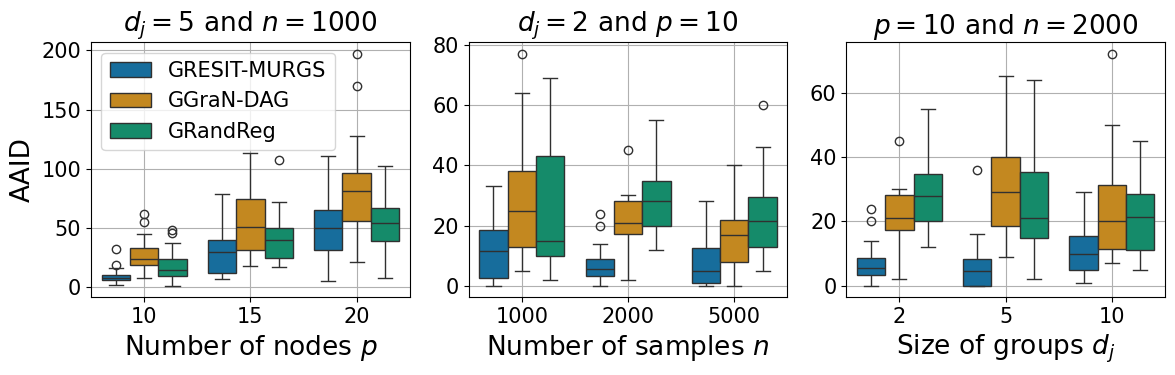

In [11]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
n_samples = 1000
n_2000 = 2000
n_nodes = 10
gs_5 = 5
gs_2 = 2

df = df_all[(df_all.n_samples == n_samples) & (df_all.gs == gs_5)]
ax = axes[0]
sns.boxplot(
    df,
    ax=ax,
    x="n_nodes",
    y="aaid",
    hue="Algorithm",
    palette="colorblind",
)
ax.set_xlabel("Number of nodes $p$")
ax.grid()
leg = ax.legend()
leg.set_title("")
ax.set_title(f"$d_j={5}$ and $n={n_samples}$")
ax.set_ylabel("AAID")

df = df_all[(df_all.n_nodes == n_nodes) & (df_all.gs == gs_2)]
ax = axes[1]
sns.boxplot(
    df,
    ax=ax,
    x="n_samples",
    y="aaid",
    hue="Algorithm",
    palette="colorblind",
)
ax.set_xlabel("Number of samples $n$")
ax.grid()
ax.set_title(f"$d_j={2}$ and $p=10$")
ax.set_ylabel("")
ax.get_legend().remove()


df = df_all[(df_all.n_nodes == n_nodes) & (df_all.n_samples == n_2000)]
ax = axes[2]
sns.boxplot(
    df,
    ax=ax,
    x="gs",
    y="aaid",
    hue="Algorithm",
    palette="colorblind",
)
ax.set_xlabel("Size of groups $d_j$")
ax.grid()
ax.set_title("$p=10$ and $n=2000$")
ax.set_ylabel("")
ax.get_legend().remove()


plt.tight_layout()
# fig.savefig("your_path_here", bbox_inches=0, pad_inches=1) # Uncomment to save the figure